In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [54]:
folder = r'C:\Projects\fin566_fall_2020_group_three\backtestingResults'
stra_inst = ['T3INTC', 'T3JPM', 'T3MSFT', 'T3AAPL']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
experiments = ['SPY2COMP', 'SPY2SPY', 'COMP2COMP', 'COMP2SPY']
figsize = (12,8)

## Utils

In [3]:
def find_file(folder, strategy_instance, file_type):
    """
    """
    regex = re.compile('(.*{}.*{}.*)'.format(ins, file_type))
    for root, dirs, files in os.walk(folder):
          for file in files:
                if regex.match(file):
                    return file

## Trade Analysis

### collect fill order

In [6]:
experiment = 'SPY2COMP'
fills = {}
for ins in stra_inst:
    print('{}-{}'.format(experiment,ins))
    file = find_file(os.path.join(folder, experiment), ins, 'fill')
    data = pd.read_csv(os.path.join(folder, experiment, file), usecols=[1,3,4,5], parse_dates=[0])
    fills['{}-{}'.format(experiment,ins)] = data

SPY2COMP-T3INTC
SPY2COMP-T3JPM
SPY2COMP-T3MSFT
SPY2COMP-T3AAPL


### Calculate Cost and Profit

In [33]:
for ins in stra_inst:
    
    data = fills['{}-{}'.format(experiment,ins)]
    
    pnls = [0] * data.shape[0]   ## for buy order, it represent money used to build position. for sell order, it means 
    buy_cost, buy_size = 0, 0
    for i in range(data.shape[0]):
        if data.iloc[i,1] >= 0:
            buy_cost += data.iloc[i,1] * data.iloc[i,2]
            buy_size += data.iloc[i,1]
            pnls[i] = buy_cost
        else:
            assert abs(data.iloc[i,1]) == buy_size
            pnls[i] = abs(data.iloc[i,1]) * data.iloc[i,2] - buy_cost
            buy_size = 0
            buy_cost = 0
            
    data['pnl_trade'] = pnls
    # For buy order, it represent money used to build position. 
    # For sell order, it means the selling profit.
    
    fills['{}-{}'.format(experiment,ins)] = data
    print('finished {}-{}'.format(experiment,ins))

finished SPY2COMP-T3INTC
finished SPY2COMP-T3JPM
finished SPY2COMP-T3MSFT
finished SPY2COMP-T3AAPL


### Wining trade / Average profit / Average loss

SPY2COMP-T3INTC. sell trades:987; win rate:0.495; ave win pft:0.057; ave loss:-0.049
SPY2COMP-T3JPM. sell trades:973; win rate:0.460; ave win pft:0.093; ave loss:-0.089
SPY2COMP-T3MSFT. sell trades:1275; win rate:0.539; ave win pft:0.141; ave loss:-0.066
SPY2COMP-T3AAPL. sell trades:1092; win rate:0.564; ave win pft:0.193; ave loss:-0.148


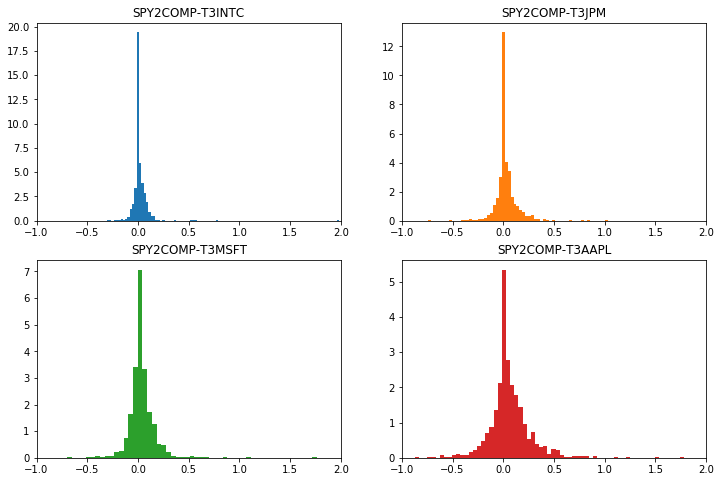

In [62]:
fig, axs = plt.subplots(2, 2, figsize=figsize)

for ins, ax, c in zip(stra_inst, np.ravel(axs), colors):
    
    data = fills['{}-{}'.format(experiment,ins)]
    sell = data[data['Quantity'] < 0]
    win = sell[sell['pnl_trade'] > 0]
    loss = sell[sell['pnl_trade'] < 0]
    
    wr = win.shape[0] / sell.shape[0]   # wining rate
    win_ave_pnl = - sum(win['pnl_trade'])/sum(win['Quantity'])
    loss_ave_pnl = - sum(loss['pnl_trade'])/sum(loss['Quantity'])
    
    ax.hist((sell['pnl_trade'] / abs(sell['Quantity'])), bins=100, color=c, density=True)
    ax.set_title('{}-{}'.format(experiment,ins))
    ax.set_xlim(-1,2)
    print("{}-{}. sell trades:{}; win rate:{:.3f}; ave win pft:{:.3f}; ave loss:{:.3f}".format(experiment, ins, sell.shape[0], wr, win_ave_pnl, loss_ave_pnl))

### Trade Frequency

C:\Python3\Lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Python3\Lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Python3\Lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

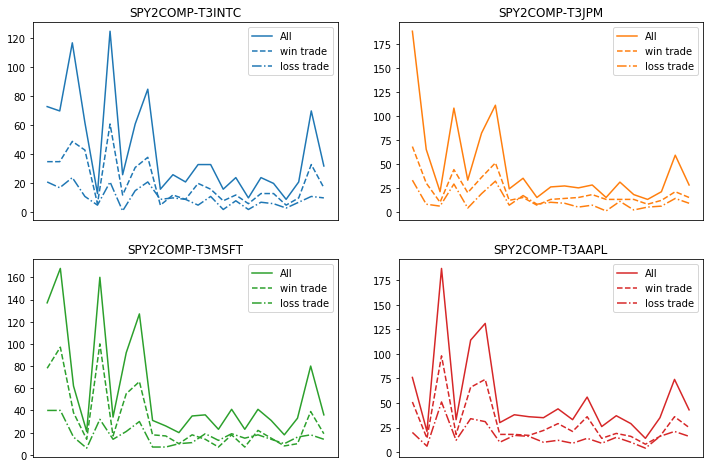

In [79]:
fig, axs = plt.subplots(2, 2, figsize=figsize)

for ins, ax, c in zip(stra_inst, np.ravel(axs), colors):
    
    data = fills['{}-{}'.format(experiment,ins)]
    sell = data[data['Quantity'] < 0]
    
    sell['date'] =  sell['TradeTime'].apply(lambda x: datetime.strftime(x, format='%m-%d'))
    sell_count = sell.groupby('date').count()
    win = sell[sell['pnl_trade'] > 0]
    win_count = win.groupby('date').count()
    loss = sell[sell['pnl_trade'] < 0]
    loss_count = loss.groupby('date').count()
    
    ax.plot(sell_count['Quantity'], color=c, linestyle='-')
    ax.plot(win_count['Quantity'], color=c, linestyle='--')
    ax.plot(loss_count['Quantity'], color=c, linestyle='-.')
    
    ax.set_title('{}-{}'.format(experiment,ins))
    ax.xaxis.set_ticklabels([])
    ax.set_xticks([])
    ax.legend(['All', 'win trade', 'loss trade'])